# Actor processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

/Users/star/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1.Load the supplied dataset
We first start by loading supplied datasets.

In [2]:
DATA_PATH = "./MovieSummaries/"

#Normalizing the column names of the dataframe
movie_columns = ['WID', 'FID', 'MovieName', 'MovieReleaseDate', 'MovieBoxOfficeRevenue', 'MovieRuntime', 'MovieLanguages', 'MovieCountries', 'MovieGenres']
characters_columns = ['WID','FID','MovieReleaseDate','CharacterName','ActorDOB','ActorGender','ActorHeight','ActorEthnicity','ActorName','ActorAgeAtMovieRelease','FreebaseCharacterMap1','FreebaseCharacterMap2','FreebaseCharacterMap3']

In [3]:
#Load two dataframes
movies = pd.read_csv(DATA_PATH+"movie.metadata.tsv", sep='\t', names=movie_columns)
characters = pd.read_csv(DATA_PATH+"character.metadata.tsv", sep='\t', names=characters_columns)

## 2.  Basic cleaning
We want to study the transformation of actors, and we clean the data in two separate tables according to the needs of our study.  
Let's start with the charcters dataframe, which is the most important for us.

### 2.1 Characters dataframe

In [4]:
#Checking samples and try to find problems
characters.sample(10)

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,FreebaseCharacterMap1,FreebaseCharacterMap2,FreebaseCharacterMap3
140277,4550020,/m/0c8dk8,1971-09-10,NaN,1938-07-12,F,NaN,NaN,Ronnie Bierman,33.0,/m/02vcdyg,NaN,/m/02q_jzt
133947,27809124,/m/0cc9cl7,1949-04-13,Caradoc,1891-06-19,M,NaN,NaN,Roddy Hughes,NaN,/m/0g8w211,/m/0g8w214,/m/0cc6n_4
258052,5080099,/m/0d1sxj,1972-01-26,NaN,1948,NaN,NaN,NaN,Topo Swope,24.0,/m/0djd5r0,NaN,/m/06zt8z7
185892,2444294,/m/07dgx0,1950-08-03,NaN,1931-12-20,F,NaN,NaN,Mala Powers,18.0,/m/02kphzx,NaN,/m/06jpjl
291609,14747692,/m/03gwfzp,1999-12-25,Hank Goody,1930-02-10,M,1.80,NaN,Robert Wagner,69.0,/m/040mrj9,/m/0cgzn59,/m/02fb1n
336127,28744719,/m/0cz955h,1978-05,NaN,1920-05-21,M,NaN,NaN,Anthony Steel,NaN,/m/0czydp2,NaN,/m/08w4s6
63968,685977,/m/032xrj,1984-05-04,Jim Baker,1928-02-22,M,1.78,NaN,Paul Dooley,56.0,/m/0k3c2q,/m/0h5q70v,/m/07ddz9
94036,223268,/m/01gkp1,2001-10-05,Henry Sherman,1946-07-22,M,1.92,/m/0x67,Danny Glover,55.0,/m/0k6bfj,/m/0gkpxjv,/m/0205dx
262284,1267357,/m/04nmdn,1978-08-29,NaN,1953-01-19,M,1.80,NaN,"Desi Arnaz, Jr.",25.0,/m/0jsyvh,NaN,/m/02t9qj
179760,26660584,/m/0bh9bth,1929-10-06,NaN,1894-07-25,M,1.80,NaN,Walter Brennan,NaN,/m/0g9hdps,NaN,/m/02f6s3


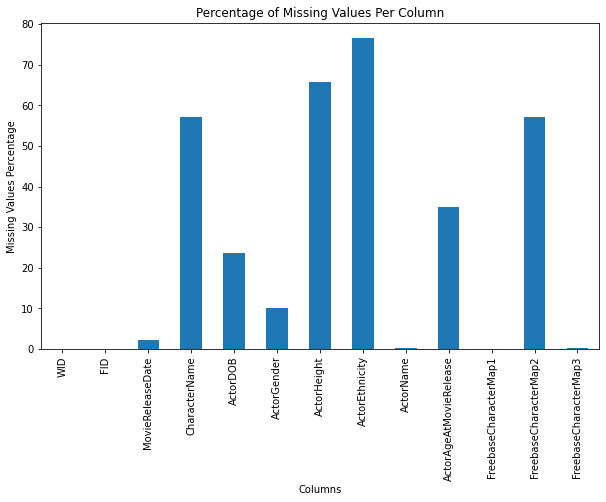

In [5]:
#View missing values for each column

# Counting the percentage of missing values 
missing_percentage = (characters.isnull().sum() / len(characters)) * 100

# Plot
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Percentage')
plt.show()

Combining the previous information and the questions to be analyzed, the following data were cleaned  
1. Remove rows with ActorName of NaN since the research question is actors' transformation.  
2. Unify the date format and deal with the wrong data  
3. Use movie release date - actor dob to make up for the missing actor age data  

#### 2.1.1 Remove rows with ActorName of NaN 

In [6]:
characters_drop = characters.dropna(subset=['ActorName']).copy()

#### 2.1.2 Unify the format of the date

In [7]:
characters_date_change = characters_drop.copy()
characters_date_change.loc[characters_date_change['MovieReleaseDate'] == '1010-12-02', 'MovieReleaseDate'] = '2010-12-02'
characters_date_change['MovieReleaseDate'] = pd.to_datetime(characters_date_change['MovieReleaseDate'], errors='coerce').dt.year
characters_date_change['ActorDOB'] = pd.to_datetime(characters_date_change['ActorDOB'], errors='coerce').dt.year

#Create a mask to mark rows with a birth date later than the release date (424rows)
mask = characters_date_change['ActorDOB'] > characters_date_change['MovieReleaseDate']

#invalid_rows = characters_data_change[mask]
#print(invalid_rows)

# Delete these rows
characters_date_change = characters_date_change[~mask]

#Check
characters_date_change[characters_date_change['ActorDOB'] > characters_date_change['MovieReleaseDate']]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,FreebaseCharacterMap1,FreebaseCharacterMap2,FreebaseCharacterMap3


In [8]:
characters_date_change.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449258 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     449258 non-null  int64  
 1   FID                     449258 non-null  object 
 2   MovieReleaseDate        273013 non-null  float64
 3   CharacterName           192416 non-null  object 
 4   ActorDOB                329691 non-null  float64
 5   ActorGender             404867 non-null  object 
 6   ActorHeight             154756 non-null  float64
 7   ActorEthnicity          106016 non-null  object 
 8   ActorName               449258 non-null  object 
 9   ActorAgeAtMovieRelease  292360 non-null  float64
 10  FreebaseCharacterMap1   449258 non-null  object 
 11  FreebaseCharacterMap2   192424 non-null  object 
 12  FreebaseCharacterMap3   449258 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 48.0+ MB


#### 2.1.3.Supplementing missing data on actors' ages with movie release dates - actors' birth dates

In [9]:


# Find rows where age is missing but date of birth and date of appearance are not missing
characters_age_change = characters_date_change.copy()
mask2 = characters_age_change['ActorAgeAtMovieRelease'].isnull() & \
        characters_age_change['ActorDOB'].notnull() & \
        characters_age_change['MovieReleaseDate'].notnull() \


# Calculate age for these rows
characters_age_change.loc[mask2, 'ActorAgeAtMovieRelease'] = (
                                        characters_age_change.loc[mask2, 'MovieReleaseDate'] - \
                                        characters_age_change.loc[mask2, 'ActorDOB']
                                                             )


# Show rows with updated age data（21036 rows updated）
characters_age_change[mask2]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,FreebaseCharacterMap1,FreebaseCharacterMap2,FreebaseCharacterMap3
86,31983669,/m/0g4_n3m,1931.0,"Tomka Zhigan, leader of the wild boys",1899.0,M,NaN,NaN,Mikhail Zharov,32.0,/m/0g4_ndp,/m/0g4_nbx,/m/07m08h
93,31983669,/m/0g4_n3m,1931.0,NaN,1887.0,M,NaN,NaN,Vladimir Uralsky,44.0,/m/0g4_nfp,NaN,/m/0jt1q2
97,31983669,/m/0g4_n3m,1931.0,Nikolai Sergeiev,1899.0,M,NaN,NaN,Nikolai Batalov,32.0,/m/0g4_nd9,/m/0g4_nbj,/m/0jt1lz
98,17715326,/m/047t9rb,1935.0,NaN,1888.0,M,NaN,NaN,Graham McNamee,47.0,/m/0jz1t0_,NaN,/m/07g4h_
195,14631844,/m/03grb4v,1917.0,NaN,1891.0,M,NaN,NaN,Wallace Reid,26.0,/m/0cg2rbf,NaN,/m/03q8vb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450605,7762741,/m/0kvgqq,1914.0,NaN,1883.0,M,NaN,NaN,Jack Richardson,31.0,/m/09h_33r,NaN,/m/0ks01m
450606,7762741,/m/0kvgqq,1914.0,NaN,1871.0,M,NaN,NaN,Harry von Meter,43.0,/m/09h_33l,NaN,/m/0kr_7z
450607,21975745,/m/05p4tmc,1938.0,NaN,1894.0,M,NaN,NaN,Billy Bletcher,44.0,/m/0gw3w0l,NaN,/m/06f_qn
450611,15567100,/m/03mfb7j,1922.0,NaN,1881.0,M,NaN,NaN,Duke R. Lee,41.0,/m/040nz44,NaN,/m/03c74h7


In [10]:
#Clearing age is negative(199rows,MovieReleaseDate,ActorDOBat least one missing )
negative_age_mask = characters_date_change['ActorAgeAtMovieRelease'] < 0
indices_to_drop = characters_date_change[negative_age_mask].index

#Delete these rows
characters_date_change = characters_date_change.drop(indices_to_drop)

#Check
characters_date_change[characters_date_change['ActorAgeAtMovieRelease'] < 0]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,FreebaseCharacterMap1,FreebaseCharacterMap2,FreebaseCharacterMap3


### 2.2 Movies Dataframe
Let's move on to the movies dataframe.

In [11]:
#Checking samples and try to find problems
movies.head(10)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [12]:
import json
#Processing format
movies_format = movies.copy()

movies_format['MovieLanguages'] = movies_format['MovieLanguages'].apply(lambda x: "".join(list(json.loads(x).values())))
movies_format['MovieCountries'] = movies_format['MovieCountries'].apply(lambda x: "".join(list(json.loads(x).values())))
movies_format['MovieGenres'] = movies_format['MovieGenres'].apply(lambda x: ",".join(list(json.loads(x).values())))
movies_format['MovieGenres'] = movies_format['MovieGenres'].str.split(',')
movies_format.head()

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,German Language,Germany,[Drama]


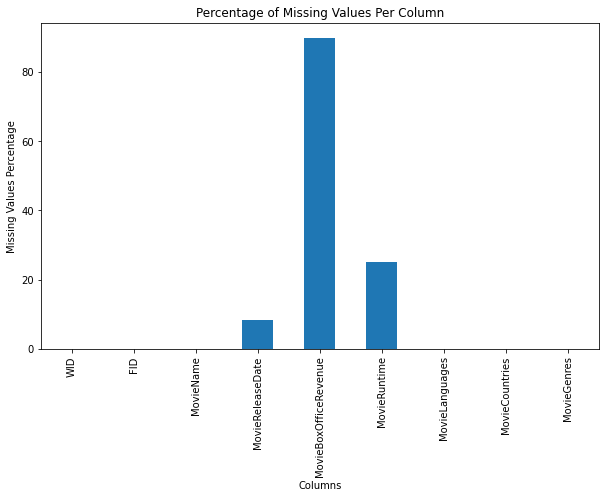

In [13]:
#View missing values for each column

# Counting the percentage of missing values 
missing_percentage = (movies_format.isnull().sum() / len(movies)) * 100

# Plot
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Percentage')
plt.show()

Since our goal is to explore actors' transformations in relation to the genres of movies, the main operations on the movies dataframe are as follows:  
1. Counting the frequency of genres words, formatting, selecting the main genres and further filtering accordingly.
2. Unify the date format and deal with the wrong data
3. Importing external datasets to make up for the large amount of missing box office data. Create new columns after processing to account for inflation.

#### 2.2.1 Handling the genres

In [14]:
#Statistical word frequency
movies_format['MovieGenres'] = movies_format['MovieGenres'].apply(lambda x: x if isinstance(x, list) else [])
categories = movies_format['MovieGenres'].explode().value_counts()
sorted_category_counts = categories.sort_values(ascending=False)
print(sorted_category_counts.head(50))

MovieGenres
Drama                     34007
Comedy                    16349
Romance Film              10234
Black-and-white            9094
Action                     8798
Thriller                   8744
Short Film                 8141
World cinema               7155
Crime Fiction              6948
Indie                      6897
Documentary                5630
Horror                     5280
Silent film                5250
Adventure                  4963
Family Film                4598
Action/Adventure           4561
Comedy film                4362
Musical                    4160
Animation                  3534
Romantic drama             3372
Mystery                    3195
Science Fiction            3052
Fantasy                    2820
Romantic comedy            2680
War film                   2652
Japanese Movies            2322
                           2294
Western                    2226
Crime Thriller             2122
Period piece               1758
Comedy-drama               1

In [15]:
#Further cleaning of MovieGenres accoding to our observation

import copy

#Common genres of our selection
selected_genres = ['Comedy', 'Drama', 'Romance', 'Action', 'Thriller', 'Crime', 'Documentary', 'Horror', 'Adventure', 'Musical' , 'Animation', 'Science Fiction', 'Fantasy', 'Western', 'War film', 'Biography', 'Sports', 'Martial Arts Film', 'Hisorty', 'Detective']

# clean the genre,use deepcopy to make sure there will be no change in previous dataframe
genre = [copy.deepcopy(x) for x in movies_format["MovieGenres"].values]
movie_genres_selected = []

#Unify genres‘ data and filter the “drama” genres
for line in genre:
    selected = []
    for g in line:
        if g in selected_genres:
            selected.append(g)
        elif g in ['Romance Film', 'Romantic drama', 'Romantic comedy']:
            selected.append('Romance')
        elif g in ['Crime Fiction', 'Crime Thriller', 'Crime Drama']:
            selected.append('Crime')
        elif g in ['Action/Adventure']:
            selected.append('Adventure')
            selected.append('Action')
        elif g in ['Black comedy', 'Comedy film', 'Comedy-drama', 'Sex comedy', 'Comedy of manners', 'Musical comedy', 'Horror Comedy', 'Fantasy Comedy']:
            selected.append('Comedy')
        elif g in ['Action Thrillers']:
            selected.append('Action')
            selected.append('Thriller')
        elif g in ['Detective fiction']:
            selected.append('Detective')
        elif g in ['Historical drama', 'Historical fiction']:
            selected.append('History')
        elif g in ['Wuxia']:
            selected.append('Martial Arts Film')
    
    # remove the duplicates and sort list of genres by the initial letter
    sorted_set_genres = sorted(set(selected))
    
    movie_genres_selected.append(sorted_set_genres)
    
movies_genres_filter = movies_format.copy()
movies_genres_filter["MovieGenresSelected"] = movie_genres_selected

In [16]:
# calculate the proportion of empty selected genres
movies_genres_filter[movies_genres_filter["MovieGenresSelected"].map(len) == 0].shape[0]/movies_genres_filter.shape[0]

0.1146670581470743

Our selection can cover 89% of the data.

In [17]:
# drop rows where there is no movie genre selected
movies_genres_clean = movies_genres_filter[movies_genres_filter["MovieGenresSelected"].map(len) > 0].copy()
movies_genres_clean.sample(10)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected
23515,3365103,/m/097vll,Pope John Paul II,2005-12-04,NaN,201.0,English Language,PolandUnited States of AmericaItaly,"[Biographical film, Drama, Television movie]",[Drama]
58486,31677272,/m/0gmbrxr,Le Miracle des loups,NaN,NaN,NaN,,,"[Historical fiction, Drama]","[Drama, History]"
43791,7757334,/m/0kvgn9,The Great Gatsby,2000,NaN,100.0,English Language,United States of AmericaUnited Kingdom,"[Television movie, Period piece, Drama, Film a...","[Drama, Romance]"
50749,36181962,/m/0k0tczg,A Girl Named Mary,1919-12-21,NaN,NaN,English Language,United States of America,"[Romance Film, Drama, Silent film]","[Drama, Romance]"
68400,12000,/m/034zd,Godzilla vs. Biollante,1989-12-16,NaN,105.0,Japanese LanguageEnglish Language,Japan,"[Science Fiction, Horror, Creature Film, Fanta...","[Fantasy, Horror, Science Fiction]"
11198,213251,/m/01f7g_,Alien³,1992-05-22,159773545.0,145.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T..."
72066,6552222,/m/0gb239,Bluebeard,1944-11-11,NaN,70.0,English Language,United States of America,"[Crime Fiction, Thriller, Black-and-white, Mys...","[Crime, Thriller]"
34966,34617110,/m/0j2627g,General Cemetery,2012-10-30,NaN,NaN,Spanish Language,Peru,[Horror],[Horror]
11929,28214245,/m/0cnx_x3,John Betjeman Goes By Train,1962,NaN,10.0,English Language,United Kingdom,"[Short Film, Documentary]",[Documentary]
17971,23576946,/m/06w9jvy,The Collector,2009-07-31,9444018.0,88.0,English Language,United States of America,"[Crime Fiction, Thriller, Horror, Slasher, Sus...","[Crime, Horror, Thriller]"


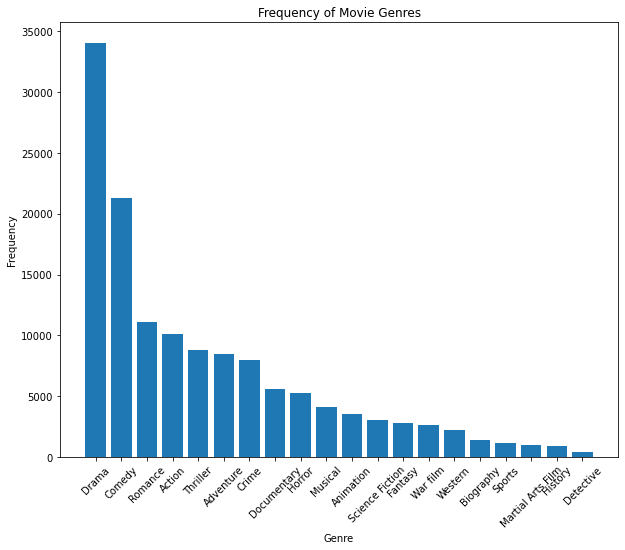

In [18]:
from collections import Counter

#Counting the frequency of every genre 

genre_counter = Counter()

# Iterate through each list in the column
for genre_list in movies_genres_clean['MovieGenresSelected']:
    genre_counter.update(genre_list)

# Converting word frequency results into a DataFrame
genre_frequency = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting to show word frequency
plt.figure(figsize=(10, 8))
plt.bar(genre_frequency['Genre'], genre_frequency['Frequency'])
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Genres')
plt.xticks(rotation=45)
plt.show()

The definition of 'Drama' is too broad, and the high frequency of dramas makes the actor's transformation harder to define. So we decide to Keep it only if the 'Drama' stands alone!

In [19]:
genre = [copy.deepcopy(x) for x in movies_genres_clean["MovieGenresSelected"].values]
movie_genres_drama_del = []

#Keeping “Drama” only when drama appears alone
for line in genre:
    # drop drama if other types exist
    if len(line) > 1 and 'Drama' in line:
        line.remove('Drama')
    
    movie_genres_drama_del.append(line)

movies_genres_drop_drama = movies_genres_clean.copy()
movies_genres_drop_drama["MovieGenresFilterDrama"] = movie_genres_drama_del

#### 2.2.2 Unify the date format and deal with the wrong data

In [20]:
#Unify the date format(Harmonization of reservations by year)
movies_date_change = movies_genres_drop_drama.copy()
movies_date_change.loc[movies_date_change['MovieReleaseDate'] == '1010-12-02', 'MovieReleaseDate'] = '2010-12-02'
movies_date_change['MovieReleaseDate'] = pd.to_datetime(movies_date_change['MovieReleaseDate'], errors='coerce').dt.year

#Change the type of the year to int
movies_date_change['MovieReleaseDate'] = movies_date_change['MovieReleaseDate'].dropna().astype(int)

#### 2.2.3 Handling the 'Revenue' column

## 3. Merge two dataframes and load external datasets
We merged the processed `characters` and `movies` and introduced a new dataset:  
1.IMDB rating  
2.Actor awards from the four major film festivals （Cannes, Berlin, Venice, Oscar）  

They will help us for subsequent analysis in causes and consequences of actor transformation.

### 3.1 Merge two main dataframes

In [21]:
#merge the processed two dataframes
characters_movies_merge = pd.merge(characters_date_change , movies_date_change, how='left', on=["WID", "FID", "MovieReleaseDate"])
characters_movies_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449059 entries, 0 to 449058
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     449059 non-null  int64  
 1   FID                     449059 non-null  object 
 2   MovieReleaseDate        272988 non-null  float64
 3   CharacterName           192390 non-null  object 
 4   ActorDOB                329531 non-null  float64
 5   ActorGender             404678 non-null  object 
 6   ActorHeight             154704 non-null  float64
 7   ActorEthnicity          105977 non-null  object 
 8   ActorName               449059 non-null  object 
 9   ActorAgeAtMovieRelease  292161 non-null  float64
 10  FreebaseCharacterMap1   449059 non-null  object 
 11  FreebaseCharacterMap2   192398 non-null  object 
 12  FreebaseCharacterMap3   449059 non-null  object 
 13  MovieName               430126 non-null  object 
 14  MovieBoxOfficeRevenu

In [22]:
#Changing data types to int to harmonize with external datasets and facilitate merging
characters_movies_date_change_type = characters_movies_merge.copy()
characters_movies_date_change_type['MovieReleaseDate'] = characters_movies_date_change_type['MovieReleaseDate'].fillna(0).astype(int)
characters_movies_date_change_type['ActorDOB'] = characters_movies_date_change_type['ActorDOB'].fillna(0).astype(int)

characters_movies_date_change_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449059 entries, 0 to 449058
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     449059 non-null  int64  
 1   FID                     449059 non-null  object 
 2   MovieReleaseDate        449059 non-null  int64  
 3   CharacterName           192390 non-null  object 
 4   ActorDOB                449059 non-null  int64  
 5   ActorGender             404678 non-null  object 
 6   ActorHeight             154704 non-null  float64
 7   ActorEthnicity          105977 non-null  object 
 8   ActorName               449059 non-null  object 
 9   ActorAgeAtMovieRelease  292161 non-null  float64
 10  FreebaseCharacterMap1   449059 non-null  object 
 11  FreebaseCharacterMap2   192398 non-null  object 
 12  FreebaseCharacterMap3   449059 non-null  object 
 13  MovieName               430126 non-null  object 
 14  MovieBoxOfficeRevenu

### 3.2 Import IMDB rating and the number of votes 

In [23]:
#Path to the referenced dataset
NEW_DATA_PATH = "./ExpandedData/"

In [24]:
#Read two tables (IMDB ratings and IMDB movies basic info) and merge the desired info together
IMDB_rating = pd.read_csv(NEW_DATA_PATH+'title.ratings.tsv', sep='\t')
IMDB_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


In [25]:
IMDB_name = pd.read_csv(NEW_DATA_PATH+'title.basics.tsv', sep='\t')
IMDB_name.head()

<ipython-input-25-9fd7d296c54b>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDB_name = pd.read_csv(NEW_DATA_PATH+'title.basics.tsv', sep='\t')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [26]:
#Delete unneeded columns
IMDB_name_delete = IMDB_name[['tconst', 'primaryTitle','startYear']].copy()
IMDB_merge = IMDB_name_delete.merge(IMDB_rating, on='tconst')
IMDB_merge.isna()['tconst'].unique()
IMDB_merge.head()

,tconst,primaryTitle,startYear,averageRating,numVotes
0,tt0000001,Carmencita,1894,5.7,2006
1,tt0000002,Le clown et ses chiens,1892,5.8,269
2,tt0000003,Pauvre Pierrot,1892,6.5,1909
3,tt0000004,Un bon bock,1892,5.5,178
4,tt0000005,Blacksmith Scene,1893,6.2,2689


In [27]:
#View startyear data
IMDB_merge['startYear'].unique()

array(['1894', '1892', '1893', '1895', '1896', '1898', '1897', '1900',
       '1899', '1901', '1902', '1903', '1904', '1912', '1907', '1905',
       '1906', '1908', '1910', '1909', '1990', '1914', '1911', '1913',
       '1919', '1916', '1917', '1915', '1918', '1936', '1925', '1922',
       '1920', '1921', '1923', '1924', '2021', '1927', '1929', '2000',
       '1926', '1993', '1935', '1928', '1942', '1930', '1931', '1932',
       '1939', '1937', '1950', '1933', '1938', '1951', '1934', '1945',
       '1946', '1940', '1944', '1949', '1947', '1941', '1952', '1970',
       '1957', '1943', '1959', '1948', '1994', '2001', '1953', '1954',
       '1965', '1983', '1980', '1973', '1961', '1995', '1955', '1962',
       '1958', '1956', '1960', '1977', '1964', '2012', '1967', '1963',
       '1988', '1968', '1971', '1969', '1972', '1966', '1976', '1979',
       '2016', '1974', '1981', '2020', '1978', '1989', '2014', '1975',
       '1986', '1985', '1987', '2010', '2018', '1996', '1992', '2023',
      

In [28]:
# Handling of outliers'\\N'
IMDB_merge['startYear'] = IMDB_merge['startYear'].replace('\\N', 0)

In [29]:
#change its type to int, in order to merge with our datasets
IMDB_merge['startYear'] = IMDB_merge['startYear'].fillna(0).astype(int)

In [30]:
#Removing Duplicate Values
IMDB_merge_new = IMDB_merge.drop_duplicates(subset=['primaryTitle', 'startYear']).reset_index(drop=True)
IMDB_merge_new

,tconst,primaryTitle,startYear,averageRating,numVotes
0,tt0000001,Carmencita,1894,5.7,2006
1,tt0000002,Le clown et ses chiens,1892,5.8,269
2,tt0000003,Pauvre Pierrot,1892,6.5,1909
3,tt0000004,Un bon bock,1892,5.5,178
4,tt0000005,Blacksmith Scene,1893,6.2,2689
...,...,...,...,...,...
1261178,tt9916708,Horrid Henry Goes Gross,2012,8.6,6
1261179,tt9916730,6 Gunn,2017,7.6,11
1261180,tt9916766,Episode #10.15,2019,7.0,22
1261181,tt9916840,Horrid Henry's Comic Caper,2014,8.8,6


In [31]:
#Left connection, import movie ratings to our dataframe
characters_movies_IMDBratings_merge = characters_movies_date_change_type.merge(
    IMDB_merge_new,
    left_on=['MovieName', 'MovieReleaseDate'],
    right_on=['primaryTitle', 'startYear'],
    how='left'
)

characters_movies_IMDBratings_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449059 entries, 0 to 449058
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     449059 non-null  int64  
 1   FID                     449059 non-null  object 
 2   MovieReleaseDate        449059 non-null  int64  
 3   CharacterName           192390 non-null  object 
 4   ActorDOB                449059 non-null  int64  
 5   ActorGender             404678 non-null  object 
 6   ActorHeight             154704 non-null  float64
 7   ActorEthnicity          105977 non-null  object 
 8   ActorName               449059 non-null  object 
 9   ActorAgeAtMovieRelease  292161 non-null  float64
 10  FreebaseCharacterMap1   449059 non-null  object 
 11  FreebaseCharacterMap2   192398 non-null  object 
 12  FreebaseCharacterMap3   449059 non-null  object 
 13  MovieName               430126 non-null  object 
 14  MovieBoxOfficeRevenu

In [32]:
# Save the required columns
characters_movies_IMDBratings_dropUnneed = characters_movies_IMDBratings_merge.drop(['primaryTitle','startYear'], axis=1)
characters_movies_IMDBratings_dropUnneed.sample(10)

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,...,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected,MovieGenresFilterDrama,tconst,averageRating,numVotes
325255,6052674,/m/0fmpnl,2006,NaN,0,NaN,NaN,NaN,Mariano Chiesa,NaN,...,NaN,90.0,Spanish Language,SpainArgentina,"[Computer Animation, Fantasy, Comedy, World ci...","[Animation, Comedy, Fantasy]","[Animation, Comedy, Fantasy]",NaN,NaN,NaN
431880,2495221,/m/07hvsy,1956,NaN,1926,F,NaN,NaN,Beverly Garland,30.0,...,NaN,70.0,English Language,United States of America,"[Thriller, Crime Fiction, Indie, Crime Drama, ...","[Action, Adventure, Crime, Thriller]","[Action, Adventure, Crime, Thriller]",tt0048682,3.3,1984.0
24268,19702661,/m/04myqw6,0,NaN,0,NaN,NaN,NaN,Robert Staats,NaN,...,NaN,76.0,English Language,United States of America,"[Romance Film, Fantasy, Sex comedy, Musical, C...","[Comedy, Fantasy, Musical, Romance]","[Comedy, Fantasy, Musical, Romance]",NaN,NaN,NaN
195469,2332592,/m/074f24,0,NaN,0,NaN,NaN,NaN,Michel Semeniako,NaN,...,NaN,96.0,French Language,France,"[Art film, World cinema, Comedy-drama, Satire,...","[Comedy, Drama]",[Comedy],NaN,NaN,NaN
407007,11691982,/m/02rp425,1951,NaN,1912,M,NaN,NaN,Frank Lovejoy,39.0,...,1300000.0,107.0,English Language,United States of America,"[Romantic comedy, Romance Film, Black-and-white]",[Romance],[Romance],tt0043595,6.0,947.0
89293,648781,/m/02_fm2,2002,Scroop,1958,M,1.790,/m/044038p,Michael Wincott,44.0,...,109578115.0,95.0,English Language,United States of America,"[Science Fiction, Adventure, Children's/Family...","[Adventure, Animation, Romance, Science Fiction]","[Adventure, Animation, Romance, Science Fiction]",tt0133240,7.2,128948.0
444894,27638152,/m/05q9kpt,2010,Jim Donner,1981,M,1.829,/m/041rx,Scott Mechlowicz,29.0,...,NaN,95.0,English Language,United States of America,"[Romantic comedy, Romantic drama, Romance Film...","[Comedy, Drama, Romance]","[Comedy, Romance]",tt1296898,5.9,20161.0
438009,31562257,/m/0glp976,2010,Sivaramakrishnan,1983,M,1.680,NaN,Dhanush,27.0,...,NaN,NaN,Telugu languageTamil Language,India,[Comedy],[Comedy],[Comedy],NaN,NaN,NaN
254397,25838671,/m/09v4lxs,1959,Policeman,1907,M,NaN,/m/019kn7,Eijirô Tono,51.0,...,NaN,117.0,Japanese Language,Japan,"[Drama, Japanese Movies]",[Drama],[Drama],tt0186273,7.6,88.0
157882,1032266,/m/03_zr8,0,Therapist,1972,F,1.730,NaN,Christa Campbell,32.0,...,84447.0,94.0,English Language,United States of America,"[Drama, Romantic drama, Romance Film, Comedy-d...","[Comedy, Drama, Romance]","[Comedy, Romance]",NaN,NaN,NaN


#### 3.3 Importing four dataset of actor awards from the four major film festivals

In [33]:
#Importing an organized dataset of actor awards in Cannes
award_columns = ['AwardYear', 'ActorName', 'CharacterName','MovieName']
Cannes = pd.read_csv(NEW_DATA_PATH+'Cannes.csv', sep=',')
Cannes.columns = award_columns
Cannes.head(200)

,AwardYear,ActorName,CharacterName,MovieName
0,1946,Ray Milland,Don Birnam,The Lost Weekend
1,1949,Edward G. Robinson,Gino Monetti,House of Strangers
2,1951,Michael Redgrave,Andrew Crocker-Harris,The Browning Version
3,1952,Marlon Brando,Emiliano Zapata,Viva Zapata!
4,1955,Spencer Tracy,John J. Macreedy,Bad Day at Black Rock
...,...,...,...,...
177,2010,Juliette Binoche,The Woman,Certified Copy
178,2011,Kirsten Dunst,Justine,Melancholia
179,2012,Cristina Flutur,Alina,Beyond the Hills
180,2012,Cosmina Stratan,Voichita,Beyond the Hills


In [34]:
#Importing an organized dataset of actor awards in Berlin
Berlin = pd.read_csv(NEW_DATA_PATH+'Berlin.csv', sep=',')
Berlin.columns = award_columns
Berlin.head(200)

,AwardYear,ActorName,CharacterName,MovieName
0,1956,Burt Lancaster,Mike Ribble,Trapeze
1,1957,Pedro Infante,Tizoc,Tizoc
2,1958,Sidney Poitier,Noah Cullen,The Defiant Ones
3,1959,Jean Gabin,Joseph Hughes Guillamume Boutier-Blainville / ...,Archimède le clochard
4,1960,Fredric March,Matthew Harrison Brady,Inherit The Wind
...,...,...,...,...
123,2011,Sareh Bayat,Razieh,A Separation
124,2011,Sarina Farhadi,Termeh,A Separation
125,2011,Kimia Hosseini,Somayeh,A Separation
126,2012,Rachel Mwanza,Komona,War Witch


In [35]:
#Importing an organized dataset of actor awards in Venice
Venice = pd.read_csv(NEW_DATA_PATH+'Venice.csv', sep=',')
Venice.columns = award_columns
Venice.head(200)

,AwardYear,ActorName,CharacterName,MovieName
0,1932,Fredric March,Dr. Henry Jekyll / Mr. Edward Hyde,Dr. Jekyll and Mr. Hyde
1,1934,Wallace Beery,Pancho Villa,Viva Villa!
2,1935,Pierre Blanchar,Rodion Raskolnikov,Crime and Punishment
3,1936,Paul Muni,Louis Pasteur,The Story of Louis Pasteur
4,1937,Emil Jannings,Matthias Clausen,Der Herrscher
...,...,...,...,...
136,2009,Kseniya Rappoport,Sonia,The Double Hour
137,2010,Ariane Labed,Marina,Attenberg
138,2011,Deanie Ip,Sister Peach,A Simple Life
139,2012,Hadas Yaron,Shira Mendelman,Fill the Void


In [36]:
# Merge Cannes with main dataframe
Cannes_key = Cannes[['ActorName', 'MovieName']]
merged_awards_Cannes = pd.merge(characters_movies_IMDBratings_dropUnneed, Cannes_key, on=['ActorName', 'MovieName'], how='left', indicator='Cannes')
merged_awards_Cannes['Cannes'] = (merged_awards_Cannes['Cannes'] == 'both').astype(int)
merged_awards_Cannes.shape

(449059, 25)

In [37]:
# Merge Berlin with main dataframe
Berlin_key = Berlin[['ActorName', 'MovieName']]
merged_awards_Berlin = pd.merge(merged_awards_Cannes, Berlin_key, on=['ActorName', 'MovieName'], how='left', indicator='Berlin')
merged_awards_Berlin['Berlin'] = (merged_awards_Berlin['Berlin'] == 'both').astype(int)
merged_awards_Berlin.shape

(449059, 26)

In [38]:
# Merge Venice with main dataframe
Venice_key = Venice[['ActorName', 'MovieName']]
merged_awards_Venice = pd.merge(merged_awards_Berlin, Venice_key, on=['ActorName', 'MovieName'], how='left', indicator='Venice')
merged_awards_Venice['Venice'] = (merged_awards_Venice['Venice'] == 'both').astype(int)
merged_awards_Venice.shape

(449059, 27)

In [39]:
# Load Oscar Dataset 
Oscar = pd.read_csv(NEW_DATA_PATH+'the_oscar_award.csv', sep=',')
Oscar.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [40]:
#Dealing with irregularities in the Oscar dataset
selected_categories = ["ACTOR", "ACTRESS", "ACTOR IN A SUPPORTING ROLE", 
                       "ACTRESS IN A SUPPORTING ROLE", "ACTOR IN A LEADING ROLE", 
                       "ACTRESS IN A LEADING ROLE"]

selected_rows = Oscar[Oscar['category'].isin(selected_categories)].copy()


selected_rows['Oscar Winner'] = 0
selected_rows['Oscar Nomination'] = 0

selected_rows.loc[selected_rows['winner'], 'Oscar Winner'] = 1
selected_rows.loc[~selected_rows['winner'], 'Oscar Nomination'] = 1

Oscar_key = selected_rows[['name', 'film', 'Oscar Winner', 'Oscar Nomination']]
Oscar_key.columns = ['ActorName', 'MovieName', 'Oscar Winner', 'Oscar Nomination' ]
Oscar_key.head()

,ActorName,MovieName,Oscar Winner,Oscar Nomination
0,Richard Barthelmess,The Noose,0,1
1,Emil Jannings,The Last Command,1,0
2,Louise Dresser,A Ship Comes In,0,1
3,Janet Gaynor,7th Heaven,1,0
4,Gloria Swanson,Sadie Thompson,0,1


In [41]:
#merge Oscar dataset with our main set
merged_awards_Oscar = pd.merge(merged_awards_Venice, Oscar_key, on=['ActorName', 'MovieName'], how='left')
merged_awards_Oscar['Oscar Winner'] = merged_awards_Oscar['Oscar Winner'].fillna(0).astype(int)
merged_awards_Oscar['Oscar Nomination'] = merged_awards_Oscar['Oscar Nomination'].fillna(0).astype(int)
merged_awards_Oscar.shape

(449060, 29)